In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
from datetime import datetime

# Data Reading

## Turin Real Data
Real Turin Data is extracted from: [https://covid19.infn.it/iss/](https://covid19.infn.it/iss/)


In [3]:
turin_real_deaths = pd.read_csv('../data/turin-real/iss_bydate_torino_deceduti.csv', delimiter=',')
turin_real_positives = pd.read_csv('../data/turin-real/iss_bydate_torino_positivi.csv', delimiter=',')
turin_real_recoveries = pd.read_csv('../data/turin-real/iss_bydate_torino_ricoveri.csv', delimiter=',')
turin_real_icu = pd.read_csv('../data/turin-real/iss_bydate_torino_terapia_intensiva.csv', delimiter=',')

In [4]:
turin_real_recoveries

,data,casi,casi_media7gg
0,2020-02-21,-9999,NaN
1,2020-02-22,-9999,NaN
2,2020-02-23,-9999,NaN
3,2020-02-24,-9999,1.142857
4,2020-02-25,-9999,1.142857
...,...,...,...
1225,2023-06-30,-9999,0.000000
1226,2023-07-01,-9999,0.142857
1227,2023-07-02,-9999,NaN
1228,2023-07-03,-9999,NaN


In [5]:
def join_based_on_min_date(df1, df2):
    min_date = min(df1['date'].min(), df2['date'].min())
    if min_date == df1['date'].min():
        left_df = df1
        right_df = df2
    else:
        left_df = df2
        right_df = df1

    merged = pd.merge(left_df, right_df, on='date', how='left')
    return merged.filter(regex=r'^(?!.*casi).*$', axis=1)

turin_real_deaths.columns = ['date','casi','deaths_7_days']
turin_real_positives.columns = ['date','casi','positives_7_days']
turin_real_recoveries.columns = ['date','casi','recoveries_7_days']
turin_real_icu.columns = ['date','casi','icu_7_days']

turin_real = join_based_on_min_date(turin_real_deaths,turin_real_positives)
turin_real = join_based_on_min_date(turin_real,turin_real_recoveries)
turin_real = join_based_on_min_date(turin_real,turin_real_icu)
turin_real

,date,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days
0,2020-02-20,NaN,NaN,NaN,NaN
1,2020-02-21,NaN,NaN,NaN,NaN
2,2020-02-22,NaN,NaN,NaN,NaN
3,2020-02-23,0.857143,NaN,NaN,NaN
4,2020-02-24,0.857143,NaN,1.142857,NaN
...,...,...,...,...,...
1231,2023-07-05,0.428571,NaN,NaN,NaN
1232,2023-07-06,0.428571,NaN,NaN,NaN
1233,2023-07-07,NaN,NaN,NaN,NaN
1234,2023-07-08,NaN,NaN,NaN,NaN


### Data Adjustment For Population

Dati estratti da: [http://dati.istat.it/Index.aspx?QueryId=18540](http://dati.istat.it/Index.aspx?QueryId=18540)


In [6]:
## Adjust data based on Turin Polulation
population_df = pd.DataFrame(columns=['Year','Region','Province','City'])

population_df.loc[len(population_df)] = [2020, 4311217,2230946,857910]
population_df.loc[len(population_df)] = [2021, 4274945,2219206,858205]
population_df.loc[len(population_df)] = [2022, 4256350,2208370,848748]
population_df.loc[len(population_df)] = [2023, 4240736,2198237,841600]

population_df

,Year,Region,Province,City
0,2020,4311217,2230946,857910
1,2021,4274945,2219206,858205
2,2022,4256350,2208370,848748
3,2023,4240736,2198237,841600


In [7]:
turin_real_data_origin = {
    'deaths_7_days':'province',
    'positives_7_days':'province',
    'recoveries_7_days':'province',
    'icu_7_days':'province'
}

turin_real_data_origin

{'deaths_7_days': 'province',
 'positives_7_days': 'province',
 'recoveries_7_days': 'province',
 'icu_7_days': 'province'}

In [45]:
def get_multiplier(variable_name, year):
    year_data = population_df[population_df['Year'] == year]
    data_from = turin_real_data_origin[variable_name]
    multiplier = 1
    if data_from == 'region':
        multiplier = year_data['City'] / year_data['Region']

    if data_from == 'province':
        multiplier = year_data['City'] / year_data['Province']

    if data_from == 'city':
        multiplier = 1

    return multiplier

def adjust_value_for_year_population(row):
    year = int(row['date'][:4])  # Extract the year from the 'date' column as an integer

    result_dictionary = {}
    for column_name, value in row.items():
        if column_name == 'date':
            result_dictionary[column_name] = value
            continue
        multiplier = get_multiplier(column_name, year)
        result_dictionary[column_name] = row[column_name] * multiplier
        #row[column_name] *= multiplier

    return pd.Series(result_dictionary)



turin_real_adjusted = turin_real.copy()
turin_real_adjusted = turin_real_adjusted.apply(adjust_value_for_year_population ,axis=1)

for columnName in turin_real_adjusted.columns:
    if columnName == 'date':
        continue
    turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])

turin_real_adjusted


C:\Users\Utente\AppData\Local\Temp\ipykernel_24360\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_24360\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_24360\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_2436

,date,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days
0,2020-02-20,NaN,NaN,NaN,NaN
1,2020-02-21,NaN,NaN,NaN,NaN
2,2020-02-22,NaN,NaN,NaN,NaN
3,2020-02-23,0.329614,NaN,NaN,NaN
4,2020-02-24,0.329614,NaN,0.439486,NaN
...,...,...,...,...,...
1231,2023-07-05,0.164080,NaN,NaN,NaN
1232,2023-07-06,0.164080,NaN,NaN,NaN
1233,2023-07-07,NaN,NaN,NaN,NaN
1234,2023-07-08,NaN,NaN,NaN,NaN


## Simulations
For simulations we read all the simulation files in a specific folder and store them in a dictionary with their simulation ID

In [9]:
simulations_logs_dir = '../data/simulations'
simulations_logs_df = {}

for sim_log_file_name in os.listdir(simulations_logs_dir):
    file_path = os.path.join(simulations_logs_dir, sim_log_file_name)
    sim_number = int(re.findall(r'\d+', sim_log_file_name)[0])

    log_df = pd.read_csv(file_path, delimiter=';')
    simulations_logs_df[sim_number] = log_df



## GHETTO FIX FOR ERROR IN LOG FILES
for simulation_index in simulations_logs_df.keys():
    if simulation_index < 34:
        continue

    shifted_df = simulations_logs_df[simulation_index].shift(periods=1, axis=1)
    # Set the new index (in this example, just using default index values)
    shifted_df.index = range(len(shifted_df))
    simulations_logs_df[simulation_index] = shifted_df

# Data Loading
The following code snippets are for loading the read data into a defined scheme (with matching names) for both the real and the similations

The overall structure should be the following:

- Date
- DeathsByDay TotalDeaths
- PositivesByDay TotalPositives

In [10]:
shared_column_names = ['Date', 'DeathsByDay', 'DeathsTotal' ,'PositivesByDay']

use_moving_average = True

## Turin Real

In [52]:
turin_data = pd.DataFrame(columns=shared_column_names)

turin_data['Date'] = pd.date_range(start=turin_real_adjusted['date'][0], periods=len(turin_real))

turin_data['DeathsByDay'] = turin_real_adjusted['deaths_7_days']
turin_data['DeathsTotal'] = turin_data['DeathsByDay'].cumsum()

turin_data['PositivesByDay'] = turin_real_adjusted['positives_7_days']

turin_data

,Date,DeathsByDay,DeathsTotal,PositivesByDay
0,2020-02-20,NaN,NaN,NaN
1,2020-02-21,NaN,NaN,NaN
2,2020-02-22,NaN,NaN,NaN
3,2020-02-23,NaN,NaN,0.329614
4,2020-02-24,NaN,NaN,0.329614
...,...,...,...,...
1231,2023-07-05,NaN,NaN,0.164080
1232,2023-07-06,NaN,NaN,0.164080
1233,2023-07-07,NaN,NaN,NaN
1234,2023-07-08,NaN,NaN,NaN


In [12]:
## Adjust data based on Turin Population

## Simulations

In [13]:
sim_start_date = turin_data['Date'][0]
sim_start_date

Timestamp('2020-02-20 00:00:00')

In [53]:
def load_one_simulation(simulation_df):
    sim = pd.DataFrame(columns=shared_column_names)

    sim['DeathsByDay'] = simulation_df['Death'].diff()
    sim['DeathsTotal'] = simulation_df['Death']

    sim['PositivesByDay'] = simulation_df['SymptomaticNew'] + simulation_df['AsymptomaticNew']

    sim['Date'] = pd.date_range(start=sim_start_date, periods=len(simulation_df))

    return sim


first_key, first_value = next(iter(simulations_logs_df.items()))
simulation_example = load_one_simulation(first_value)
simulation_example

,Date,DeathsByDay,DeathsTotal,PositivesByDay
0,2020-02-20,NaN,0,35
1,2020-02-21,0.0,0,0
2,2020-02-22,0.0,0,3
3,2020-02-23,0.0,0,48
4,2020-02-24,0.0,0,130
...,...,...,...,...
407,2021-04-02,5.0,6796,61
408,2021-04-03,3.0,6799,65
409,2021-04-04,6.0,6805,55
410,2021-04-05,1.0,6806,67


In [15]:
sims_data = {}
for sim_number, sim_original_df in simulations_logs_df.items():
    sims_data[sim_number] = load_one_simulation(sim_original_df)

# Comparative Analysis

In [102]:
simulations_to_compare = [18,38,39]

def get_data_range(start_date, days):
    start_date = turin_data['Date'][0]
    end_date =   pd.date_range(start=start_date, periods=days)[-1]
    return start_date, end_date

def plot_compare_real_sims(turin_data_in, sims_data_dictionary_in, column_name, simulations_to_show, start_date, end_date):

    fig,axes = plt.subplots(figsize=(10, 3))

    mask = (turin_data_in['Date'] >= start_date) & (turin_data_in['Date'] <= end_date)
    real_series = turin_data_in.loc[mask, column_name]
    axes.plot(real_series, label='Real')

    real_lockdown = '2020-03-11'
    real_date_series = turin_data_in.loc[mask, 'Date']
    matching_rows = real_date_series[real_date_series == pd.to_datetime(real_lockdown)].index
    if not matching_rows.empty:
        axes.axvline(matching_rows[0], color='blue', linestyle='--', label='Real Lockdown')

    for idx in simulations_to_show:
        sim_df = sims_data_dictionary_in.get(idx)

        if sim_df is not None and column_name in sim_df.columns and 'Date' in sim_df.columns:
            mask = (sim_df['Date'] >= start_date) & (sim_df['Date'] <= end_date)
            series = sim_df.loc[mask, column_name]
            axes.plot(series, label=idx)

    # Add plot labels and legend
    plt.xlabel('Days from Start')
    plt.xticks(range(0,len(real_series), 10),rotation=45)
    plt.ylabel(column_name)
    plt.legend()


    #plt.tight_layout()
    # Show the plot
    plt.show()

## Deaths

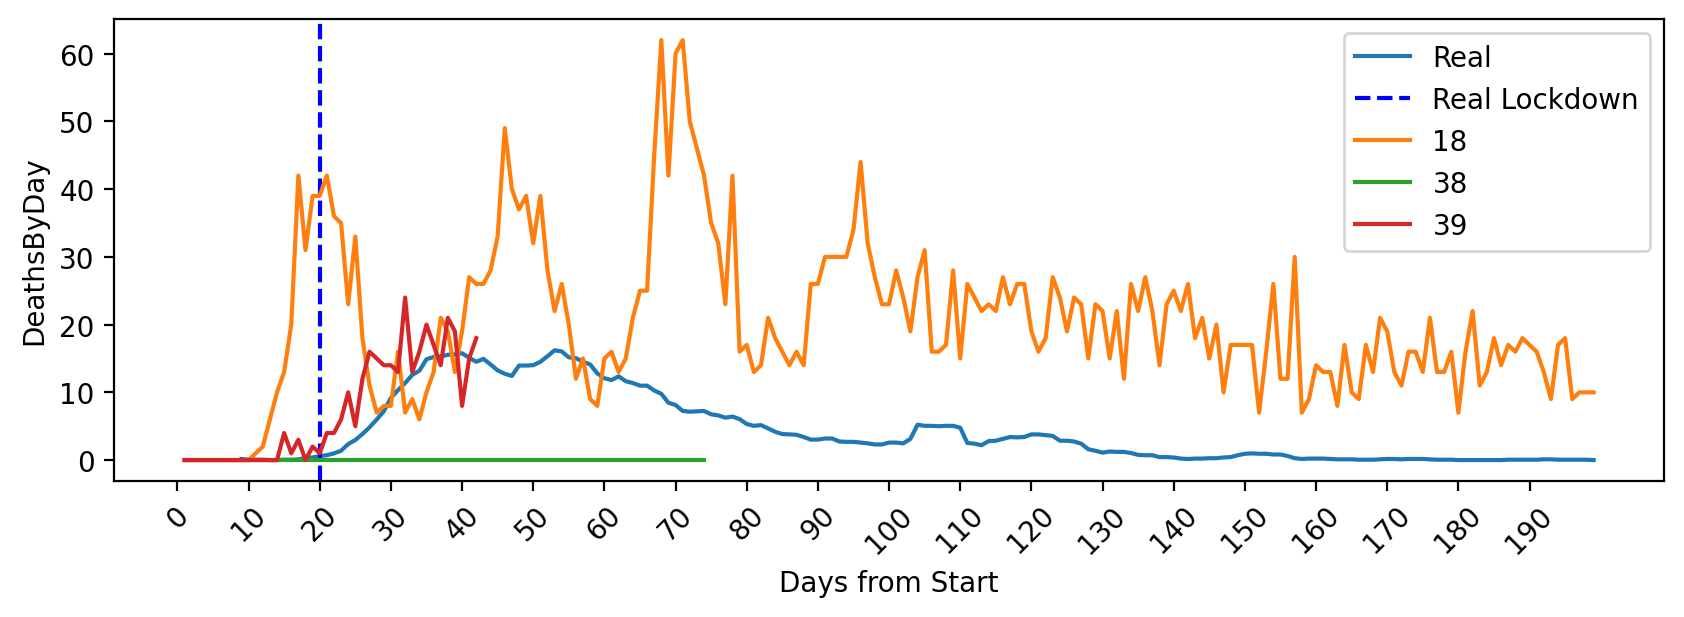

In [103]:
start_date, end_date = get_data_range(turin_data['Date'][0], 200)

plot_compare_real_sims(turin_data, sims_data, 'DeathsByDay', simulations_to_compare  ,start_date, end_date)

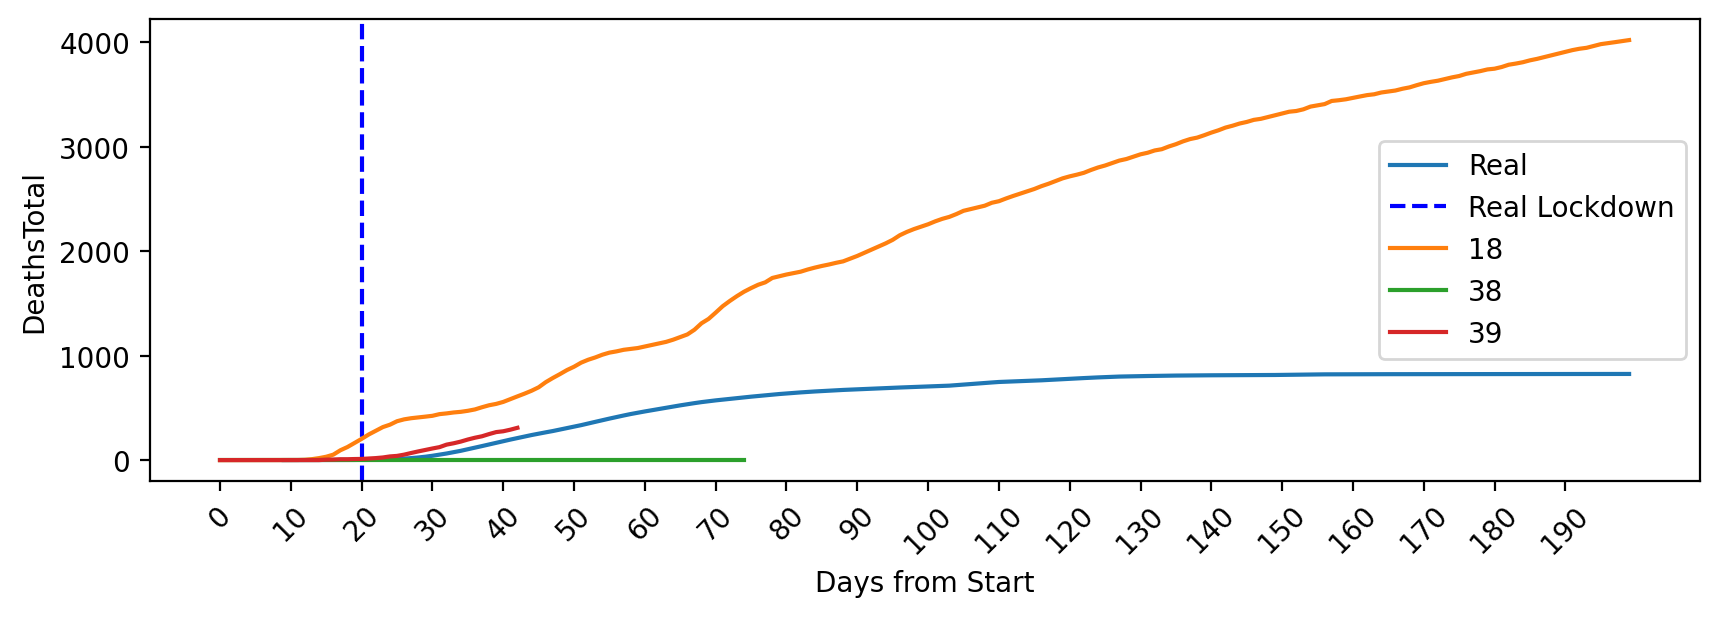

In [104]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsTotal', simulations_to_compare  ,start_date, end_date)

## Positives

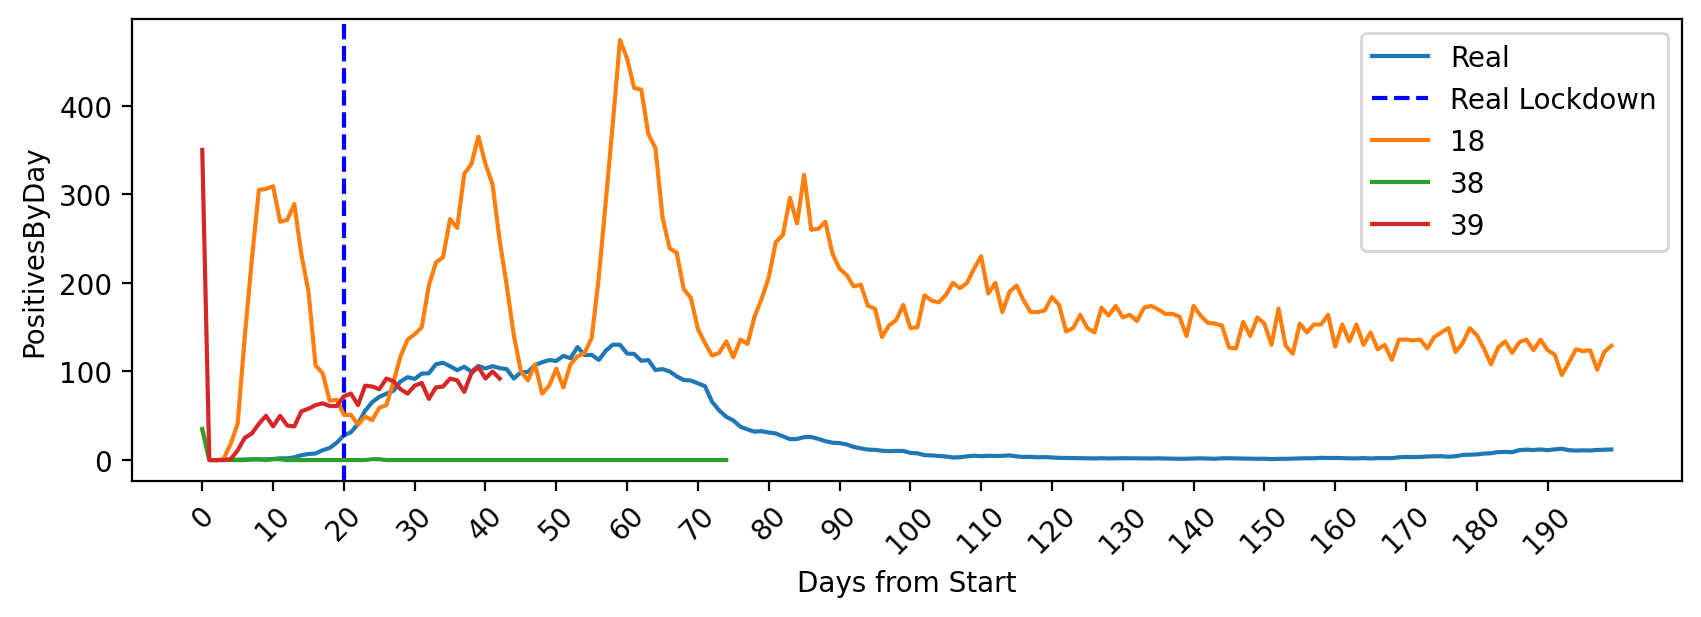

In [105]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesByDay', simulations_to_compare  ,start_date, end_date)

# Simulation Analysis
Here we have an overall analysis of only data coming from the simulations